In [1]:
import os, sys
from textwrap import wrap

import joblib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from munch import Munch
from PIL import Image
from skimage import feature as skfeat
from skimage.morphology import dilation
from tqdm import tqdm_notebook as tqdm

import datasets
import fcn_resnet

In [2]:
data_root = '../data/ddsm_raw/'
image_list_dir = '../data/ddsm_raw_image_lists/'
mask_root = '../data/ddsm_masks/3class'
config_path = '../training/pretrained/resnet152_3class/config.yml'
epoch = 5
split = 'test'

In [3]:
with open(config_path, 'r') as f:
    cfg = Munch.fromYAML(f)

In [4]:
print("=> creating model '{}'".format(cfg.arch.model))
if cfg.arch.model == 'resnet152':
    model = fcn_resnet.resnet152(num_classes=cfg.arch.num_classes)
    features_layer = model.layer4
else:
    raise Exception

model = torch.nn.DataParallel(model).cuda()

=> creating model 'resnet152'


In [5]:
resume_path = cfg.training.resume.replace(cfg.training.resume[-16:-8], '{:08}'.format(epoch))
resume_path = os.path.join('../training', resume_path)
if os.path.isfile(resume_path):
    print("=> loading checkpoint '{}'".format(resume_path))
    checkpoint = torch.load(resume_path)
    start_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    print("=> loaded checkpoint '{}' (epoch {})".format(resume_path, checkpoint['epoch']))
else:
    raise Exception("=> no checkpoint found at '{}'".format(resume_path))

=> loading checkpoint '../training/pretrained/resnet152_3class/checkpoint_00000005.pth.tar'
=> loaded checkpoint '../training/pretrained/resnet152_3class/checkpoint_00000005.pth.tar' (epoch 5)


In [6]:
model.module.surgery()

In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
patch_size = 227
dataset = datasets.DDSM(data_root, os.path.join(image_list_dir, '{}.txt'.format(split)), split, patch_size, transforms.Compose([
    transforms.ToTensor(),
    normalize,
]))

In [8]:
# extract features and max activations
features = []
def feature_hook(module, input, output):
    features.extend(output.data.cpu().numpy())
features_layer._forward_hooks.clear()
features_layer.register_forward_hook(feature_hook)
prob_maps = []
max_class_probs = []
with torch.no_grad():
    for _, image in tqdm(dataset):
        input = image.unsqueeze(0)
        input = input.cuda()
        output = model(input)
        output = output.transpose(1, 3).contiguous()
        size = output.size()[:3]
        output = output.view(-1, output.size(3))
        prob = nn.Softmax(dim=1)(output)
        prob = prob.view(size[0], size[1], size[2], -1)
        prob = prob.transpose(1, 3)
        prob = prob.cpu().numpy()
        prob_map = prob[0]
        prob_maps.append(prob_map)
        max_class_probs.append(prob_map.max(axis=(1, 2)))
max_class_probs = np.array(max_class_probs)
image_indices = np.argsort(-max_class_probs, axis=0)

In [9]:
num_top_units = 20
params = list(model.parameters())
weight_softmax = params[-2].data.cpu().numpy().squeeze(3).squeeze(2)
max_activations = np.array([feature_map.max(axis=(1, 2)) for feature_map in features])
max_activations = np.expand_dims(max_activations, 1)
weighted_max_activations = max_activations * weight_softmax
unit_indices = np.argsort(-weighted_max_activations, axis=2)
unit_indices = unit_indices[:, :, :num_top_units]

In [10]:
meta_data = joblib.load('data/ddsm_meta_data.jbl')
unit_labels = joblib.load('data/cleaned_unit_labels.jbl')

In [11]:
def print_report(image_index, class_index):
    image_name, image = dataset[image_index]
    mask_path = os.path.join(mask_root, image_name.replace('jpg', 'png'))
    if os.path.exists(mask_path):
        mask = Image.open(mask_path).resize((image.size(2), image.size(1)))
        mask = np.asarray(mask)
    else:
        print('no mask found at: {}'.format(mask_path))
        mask = None
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
        t.mul_(s).add_(m)
    image.clamp_(0, 1)
    image = image.numpy().transpose(1, 2, 0)
    print('image name: {}'.format(image_name))
    print('class {} prob: {}'.format(class_index, max_class_probs[image_index][class_index]))
    prefix = image_name.split('-')[0][:-3]
    try:
        finding = meta_data['meta'][f'{prefix}s/{image_name}']
        print(finding)
    except:
        finding = None
    prob_map = prob_maps[image_index]
    
    gs1 = gridspec.GridSpec(1, 8)
    gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 
    fig, _ = plt.subplots(figsize=(50, 50))
    
    image_size = image.shape[1::-1]
    
    ax = plt.subplot(gs1[0])
    ax.imshow(image)
    ax.set_title('Ground Truth \n Finding', fontsize=30, weight='bold')
    if finding is not None:
        ax.set_xlabel("\n".join(wrap(finding[0][1], 20)), fontsize=26, horizontalalignment='center')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    if mask is not None:
        gt_class_index = 2 if image_name.startswith('cancer')  else 1
        edges = skfeat.canny(mask == gt_class_index)
        for i in range(5):
            edges = dilation(edges)
        edges = np.ma.masked_where(edges == 0, edges)
        ax.imshow(edges, alpha=0.5, cmap='jet', vmin=0, vmax=1)
        
    heatmap = np.asarray(Image.fromarray(prob_map[class_index]).resize(image_size, resample=Image.BILINEAR))
    ax = plt.subplot(gs1[1])
    ax.imshow(image)
    cim = ax.imshow(heatmap, alpha=0.5, cmap='magma', vmin=0, vmax=1)
    ax.set_title('{} Class \n Activation Map'.format('Malignant' if class_index == 2 else 'Benign'), fontsize=30, weight='bold')
    ax.axis('off')
    
    indices = unit_indices[image_index][class_index]
    feature_maps = []
    top_feature_maps = features[image_index][indices]
    top_feature_maps = top_feature_maps - top_feature_maps.min()
    top_feature_maps = top_feature_maps / top_feature_maps.max()
    num_unit_plots = 0
    unit_rank = []
    for j, unit_index in enumerate(indices):
        if j > 6:
            break
        try:
            unit_title = '{}: {}'.format('unit_{:04}'.format(unit_index + 1), unit_labels['unit_{:04}'.format(unit_index + 1)])
            feature_map = top_feature_maps[j]
            feature_map = np.asarray(Image.fromarray(feature_map).resize(image_size, resample=Image.BILINEAR))
            feature_maps.append(feature_map)
            ax = plt.subplot(gs1[num_unit_plots+3])
            ax.imshow(image)
            ax.imshow(feature_map, alpha=0.5, cmap='magma', vmin=0, vmax=1)
            ax.set_title("\n".join(wrap(unit_title, 20)), fontsize=30)        
            num_unit_plots +=1
            unit_rank.append(j)
            if num_unit_plots == 3:
                ax.set_xlabel('DeepMiner Explanation', fontsize=36, weight='bold')
        except:
            pass
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    print('unit ranking: {}'.format(unit_rank))    
    plt.show()

image name: cancer_06-A_1168_1.LEFT_CC.LJPEG.1.jpg
class 2 prob: 0.9999998807907104
[['ABNORMALITY 1 ', 'LESION_TYPE MASS SHAPE IRREGULAR MARGINS SPICULATED', 'ASSESSMENT 4 ', 'SUBTLETY 2 ', 'PATHOLOGY MALIGNANT', 'TOTAL_OUTLINES 1 ', 'BOUNDARY']]
unit ranking: [0, 1, 2, 3, 4]


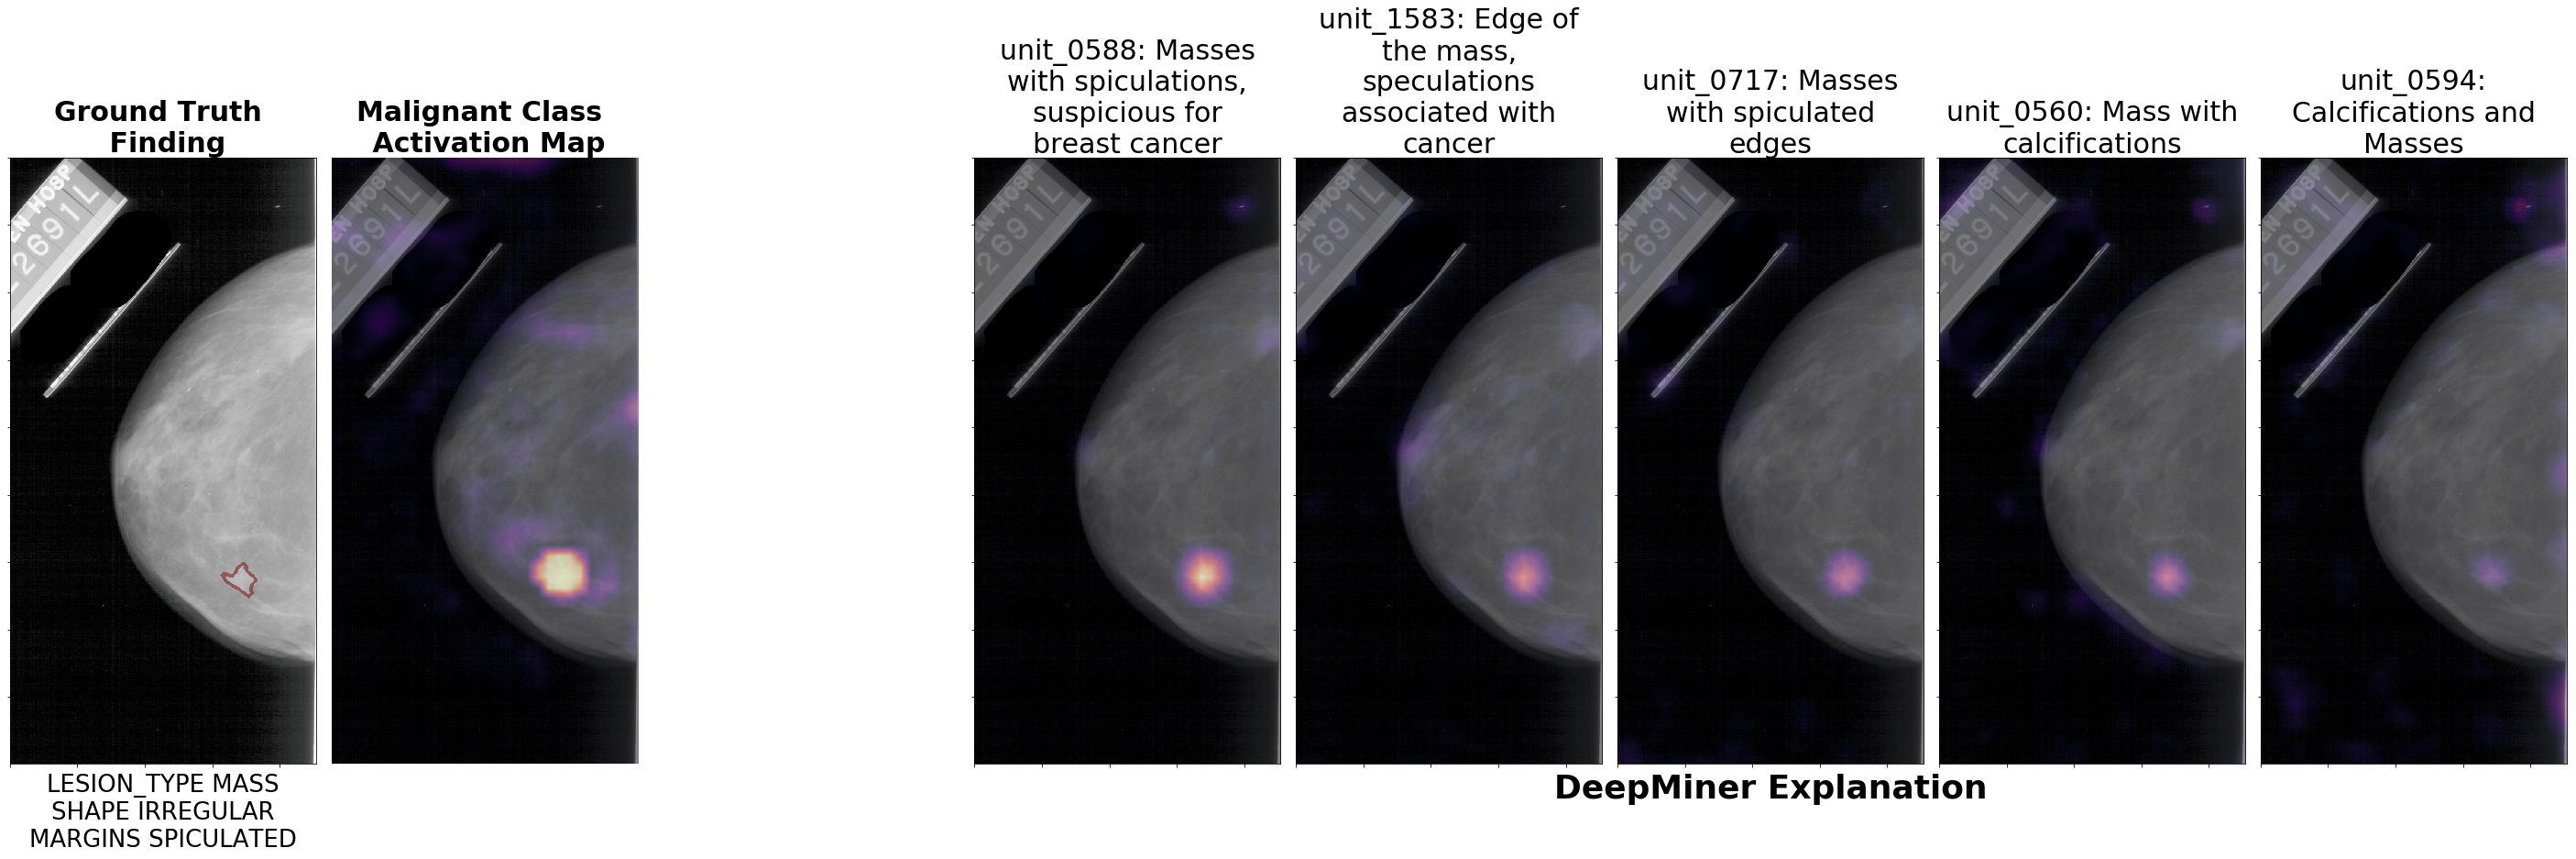

image name: benign_without_callback_02-C_0450_1.RIGHT_MLO.LJPEG.1.jpg
class 2 prob: 0.9999610185623169
[['ABNORMALITY 1', 'LESION_TYPE MASS SHAPE OVAL MARGINS CIRCUMSCRIBED', 'ASSESSMENT 3', 'SUBTLETY 4', 'PATHOLOGY BENIGN_WITHOUT_CALLBACK', 'TOTAL_OUTLINES 1 ', 'BOUNDARY']]
unit ranking: [0, 1, 2, 4]


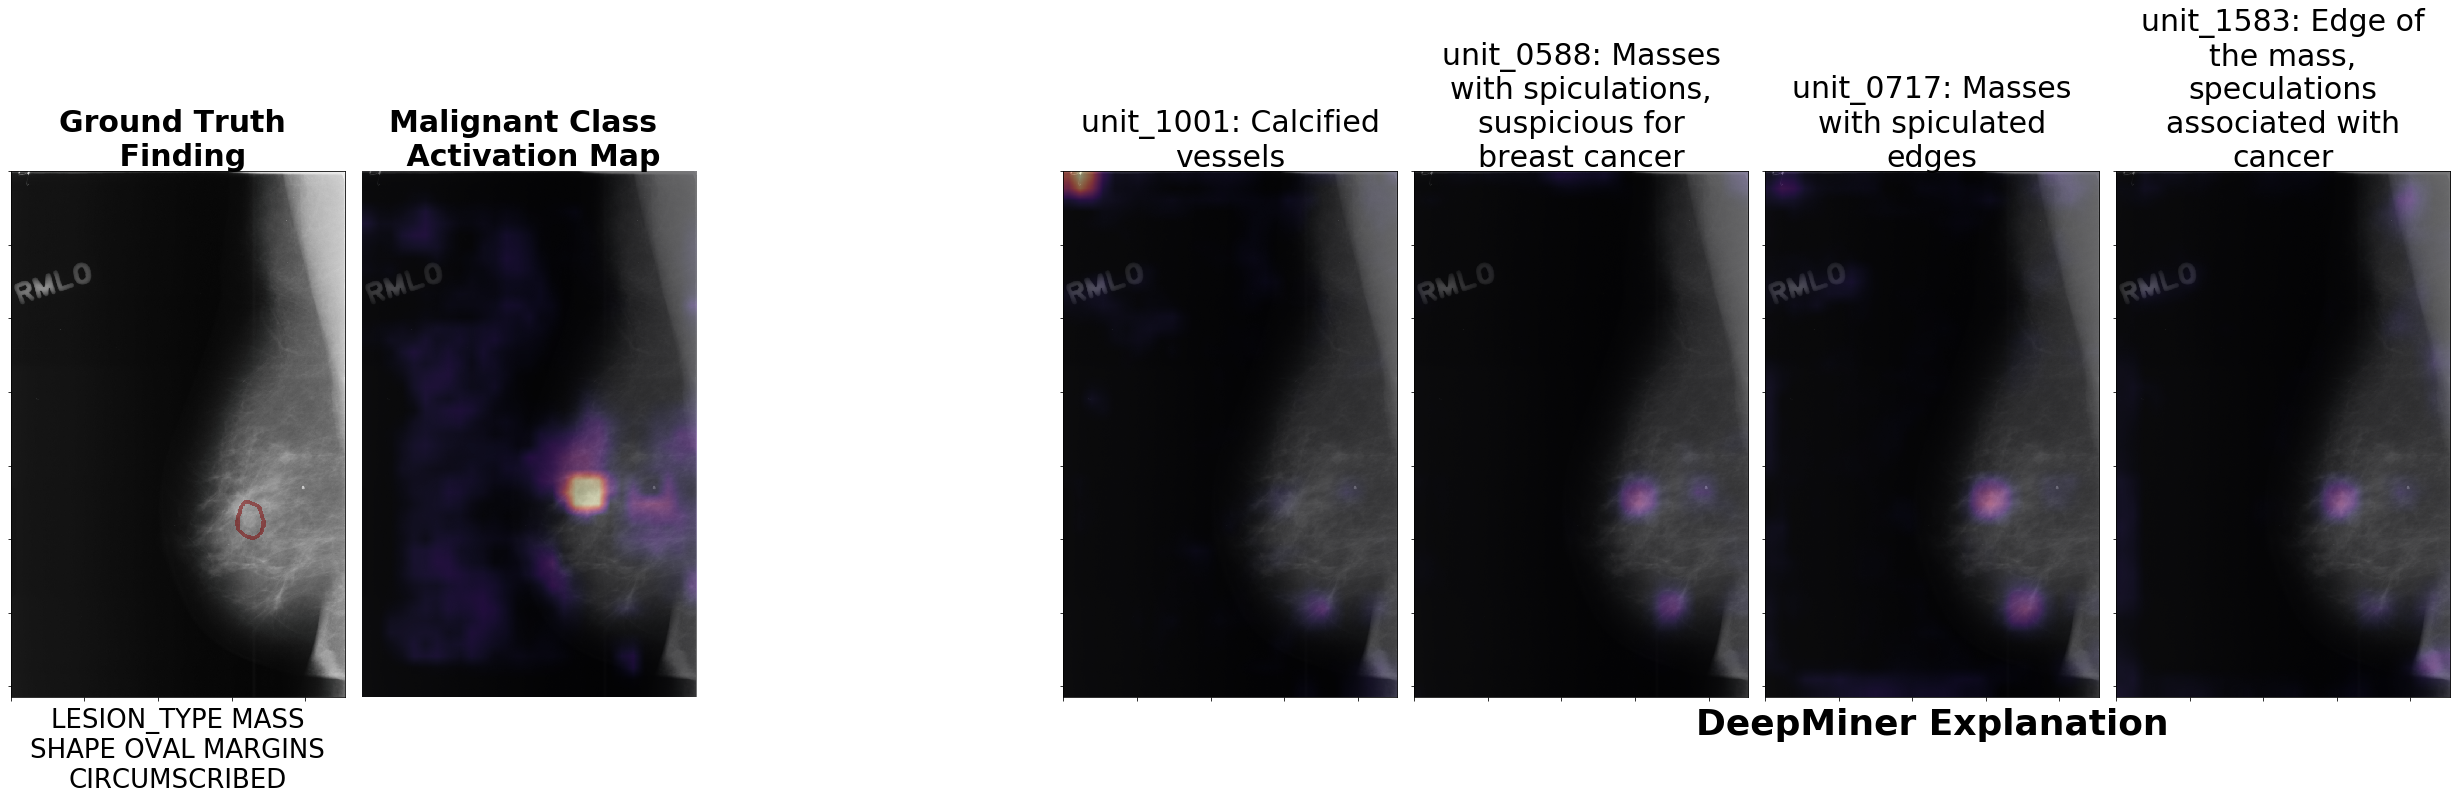

image name: benign_without_callback_01-B_3173_1.LEFT_MLO.LJPEG.1.jpg
class 1 prob: 0.9998204112052917
[['ABNORMALITY 1', 'LESION_TYPE CALCIFICATION TYPE ROUND_AND_REGULAR DISTRIBUTION N/A', 'ASSESSMENT 2', 'SUBTLETY 3', 'PATHOLOGY BENIGN_WITHOUT_CALLBACK', 'TOTAL_OUTLINES 1 ', 'BOUNDARY']]
unit ranking: [0, 1, 2, 3, 4]


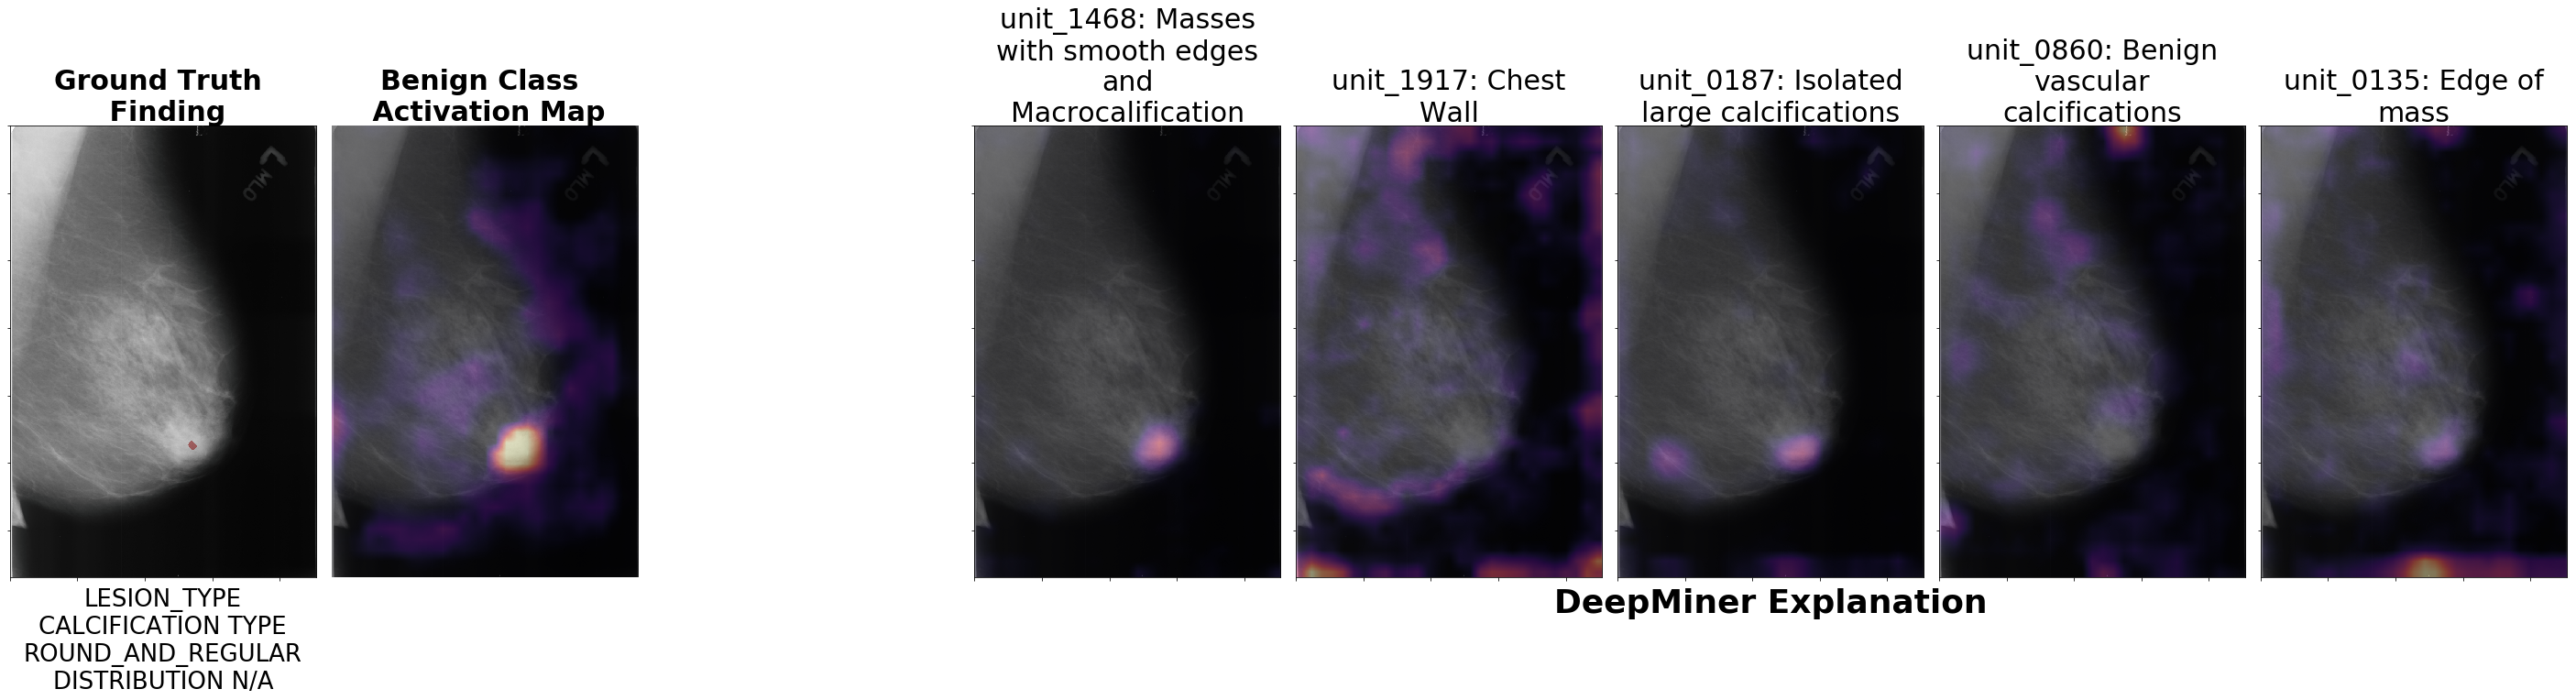

image name: cancer_04-A_1077_1.LEFT_CC.LJPEG.1.jpg
class 1 prob: 0.9999711513519287
[['ABNORMALITY 1 ', 'LESION_TYPE CALCIFICATION TYPE PLEOMORPHIC DISTRIBUTION CLUSTERED', 'ASSESSMENT 4 ', 'SUBTLETY 3 ', 'PATHOLOGY MALIGNANT', 'TOTAL_OUTLINES 1 ', 'BOUNDARY']]
unit ranking: [1, 2, 4, 5, 6]


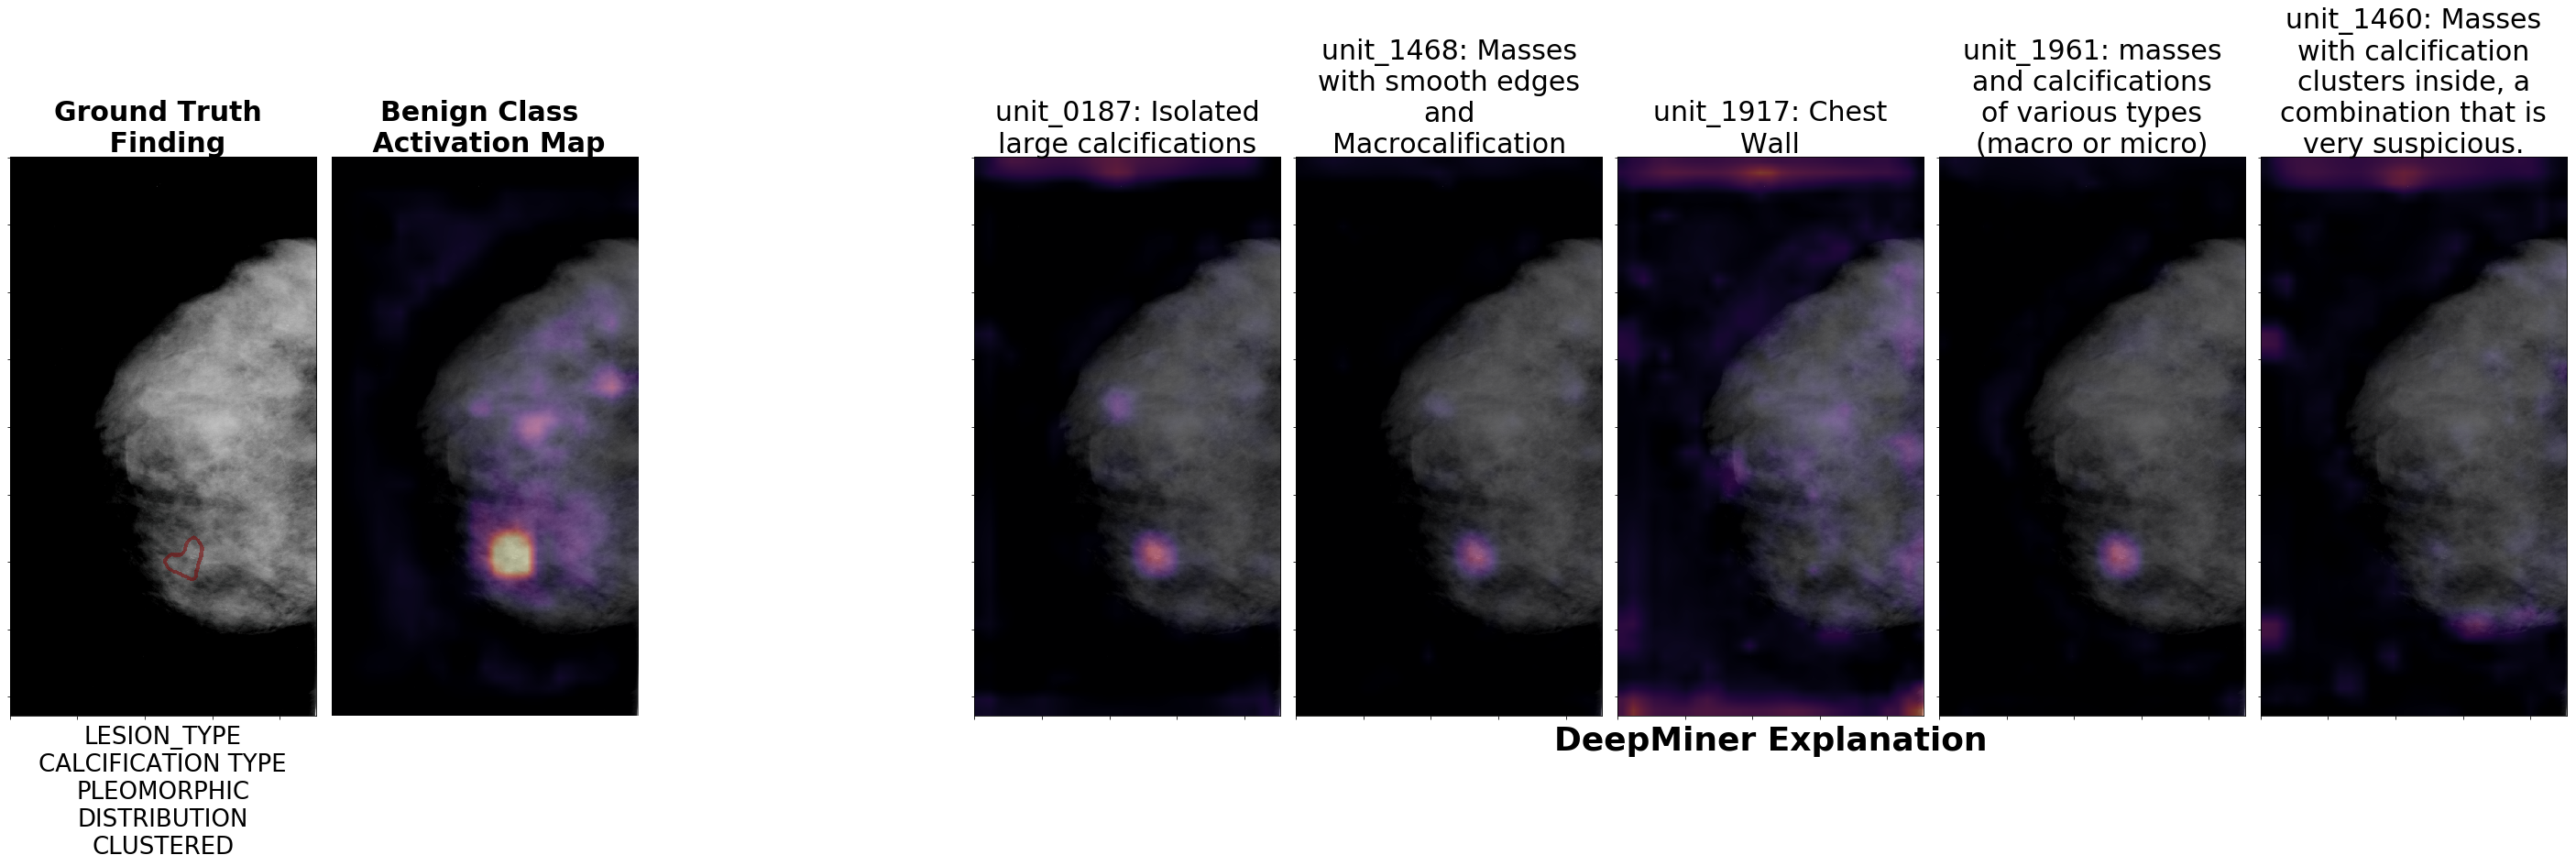

In [12]:
# Pretty Print Reports
print_report(540, 2)
print_report(395, 2)
print_report(349, 1)
print_report(464, 1)